In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import categorical_accuracy, Precision, Recall, TopKCategoricalAccuracy
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications import VGG16, VGG19
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight

2024-11-12 16:22:59.006420: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 16:22:59.029052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731446579.051311  121577 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731446579.058125  121577 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 16:22:59.081045: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU')) 

TensorFlow version: 2.18.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:8', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:9', device_type='GPU')]


In [3]:
current_path = os.getcwd()
train_dir = current_path + '/ISIC2019Dataset/data/train/'
val_dir = current_path + '/ISIC2019Dataset/data/val/'
test_dir = current_path + '/ISIC2019Dataset/ISIC_2019_test_dir/'
training_directory_path = '/ISIC2019Dataset/ISIC_2019_Training_Input/'
training_metadata_path = '/ISIC2019Dataset/ISIC_2019_Training_Metadata.csv'
ground_truth_path = '/ISIC2019Dataset/ISIC_2019_Training_GroundTruth.csv'
test_directory_path = '/ISIC2019Dataset/ISIC_2019_Test_Input/'
test_metadata_path = '/ISIC2019Dataset/ISIC_2019_Test_Metadata.csv'

training_metadata_table = pd.read_csv(current_path + training_metadata_path)
test_metadata_table = pd.read_csv(current_path + test_metadata_path)
ground_truth_table = pd.read_csv(current_path + ground_truth_path)

In [4]:
training_metadata_table

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


LABELS

- MEL - Melanoma
- NV - Melanocytic nevus
- BCC - Basal cell carcinoma
- AK - Actinic keratosis
- BKL - Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- DF - Dermatofibroma
- VASC - Vascular lesion
- SCC - Squamous cell carcinoma
- UNK - None of the above

In [5]:
training_metadata_table['age_approx'].fillna((training_metadata_table['age_approx'].mean()), inplace=True)
training_metadata_table.dropna(subset=['anatom_site_general', 'lesion_id', 'sex'], inplace=True)
training_metadata_table.isnull().sum()

/tmp/ipykernel_121577/174194398.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_metadata_table['age_approx'].fillna((training_metadata_table['age_approx'].mean()), inplace=True)


image                  0
age_approx             0
anatom_site_general    0
lesion_id              0
sex                    0
dtype: int64

In [6]:
classes=['NV','BCC','AK','BKL','DF','VASC','SCC','MEL']

ground_truth_table['label'] = ground_truth_table[classes].idxmax(axis=1)
ground_truth_table.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


In [7]:

# for c in classes:
#     # folders inside train_dir
#     class_train_dir = os.path.join(data_dir, c)
#     if not os.path.exists(class_train_dir):
#         os.mkdir(class_train_dir)

#     # folders inside val_dir
#     class_val_dir = os.path.join(data_dir, c)
#     if not os.path.exists(class_val_dir):
#         os.mkdir(class_val_dir)

In [8]:
# ground_truth_table.set_index('image', inplace=True)
# folder = os.listdir(current_path + training_directory_path)
# image_list = list(ground_truth_table.index)

# for image in image_list:
    
#     fname = image + '.jpg'
#     label = ground_truth_table.loc[image,'label']
    
#     if fname in folder:
#         src = os.path.join(current_path + training_directory_path, fname)
#         dst = os.path.join(data_dir, label, fname)
#         shutil.copyfile(src, dst)

In [9]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Define dataset paths
# data_dir = '/home/fall2019/qnd5128/capstone/SkinLesionClassification/ISIC2019Dataset/ISIC_2019_data_dir'
# base_dir = '/home/fall2019/qnd5128/capstone/SkinLesionClassification/ISIC2019Dataset/data'
# train_dir = os.path.join(base_dir, 'train')
# val_dir = os.path.join(base_dir, 'val')

# # Print paths for confirmation
# print("Base directory for split data:", base_dir)
# print("Original data directory:", data_dir)

# # Create directories for training and validation
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)

# # Get all classes (folders) in the original dataset directory
# classes = os.listdir(data_dir)

# # Split the data and organize into folders
# for class_name in classes:
#     # Create class-specific directories in train and validation folders
#     os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
#     os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    
#     # List all images in each class folder
#     images = os.listdir(os.path.join(data_dir, class_name))
#     images = [os.path.join(data_dir, class_name, img) for img in images]
    
#     # Split images into train and validation sets (e.g., 85% train, 15% validation)
#     train_images, val_images = train_test_split(images, test_size=0.15, random_state=42)
    
#     # Move images to the train directory
#     for img in train_images:
#         shutil.copy(img, os.path.join(train_dir, class_name))
    
#     # Move images to the validation directory
#     for img in val_images:
#         shutil.copy(img, os.path.join(val_dir, class_name))

# print("Data split into training and validation directories successfully.")


## Train Test Split & Data Augmentation

In [10]:
target_size = (224,224)
image_gen = ImageDataGenerator(
    preprocessing_function=vgg_16_preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_batches = image_gen.flow_from_directory(train_dir,
                                              target_size=target_size,
                                              color_mode='rgb',
                                              batch_size=32,
                                              class_mode='categorical')

val_batches = image_gen.flow_from_directory(val_dir,
                                            target_size=target_size,
                                            color_mode='rgb',
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle=False)

print(train_batches.class_indices)

Found 21527 images belonging to 8 classes.
Found 3804 images belonging to 8 classes.
{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


## Transfer Learning using Vgg16 Model

In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-5]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

W0000 00:00:1731446598.362972  121577 gpu_device.cc:2277] Unable to enable peer access between device ordinals 0 and 9, status: INTERNAL: failed to enable peer access from 0x564012927560 to 0x564017c18700: INTERNAL: CUDA error: : CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
W0000 00:00:1731446598.376074  121577 gpu_device.cc:2277] Unable to enable peer access between device ordinals 1 and 9, status: INTERNAL: failed to enable peer access from 0x56401326b390 to 0x564017c18700: INTERNAL: CUDA error: : CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
W0000 00:00:1731446598.396331  121577 gpu_device.cc:2277] Unable to enable peer access between device ordinals 2 and 9, status: INTERNAL: failed to enable peer access from 0x564013b803b0 to 0x564017c18700: INTERNAL: CUDA error: : CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
W0000 00:00:1731446598.412068  121577 gpu_device.cc:2277] Unable to enable peer access between device ordinals 3 and 9, status: IN

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 27,566,408 (105.16 MB)

 Trainable params: 19,930,120 (76.03 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

### Calculate Class Weights

In [12]:
label_to_index = train_batches.class_indices  

index_to_label = {v: k for k, v in label_to_index.items()}
ground_truth_table['label_index'] = ground_truth_table['label'].map(label_to_index)

classes = np.unique(ground_truth_table['label_index'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=ground_truth_table['label_index']
)

class_weights_dict = dict(zip(classes, class_weights))
class_weights_dict

{0: 3.652104959630911,
 1: 0.9528663857959675,
 2: 1.2066977896341464,
 3: 13.248430962343097,
 4: 0.7002156125608138,
 5: 0.24593203883495146,
 6: 5.041998407643312,
 7: 12.515316205533598}

### Training Model 

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.mixed_precision import set_global_policy

# Function to compute sample weights
def compute_sample_weights(labels, class_weights):
    sample_weights = np.array([class_weights[np.argmax(label)] for label in labels])
    return sample_weights

def generator_with_sample_weights(generator, class_weights):
    while True:
        x, y = next(generator)
        sample_weights = compute_sample_weights(y, class_weights)
        yield x, y, sample_weights


train_batches_with_weights = generator_with_sample_weights(train_batches, class_weights_dict)
valid_batches_with_weights = generator_with_sample_weights(val_batches, class_weights_dict)


model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy, 
                       Precision(name='precision'), 
                       Recall(name='recall'), 
                       TopKCategoricalAccuracy(k=3, name='top_3_accuracy')])

checkpoint = ModelCheckpoint('vgg16_checkpoint.keras', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, verbose=1, mode='max', min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True, mode='max', verbose=1)

callbacks_list = [checkpoint, reduce_lr, early_stopping]

history = model.fit(
    train_batches_with_weights,
    validation_data=valid_batches_with_weights,
    steps_per_epoch=len(train_batches),
    validation_steps=len(val_batches),
    epochs=15,
    callbacks=callbacks_list
)

# Save the final model
model.save('vgg16_full_model_after_training.keras')

Epoch 1/15


I0000 00:00:1731446615.491295  122273 service.cc:148] XLA service 0x7f7cec0077c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731446615.491322  122273 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731446615.491325  122273 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731446615.491327  122273 service.cc:156]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
I0000 00:00:1731446615.491329  122273 service.cc:156]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5
I0000 00:00:1731446615.491330  122273 service.cc:156]   StreamExecutor device (4): Tesla T4, Compute Capability 7.5
I0000 00:00:1731446615.491332  122273 service.cc:156]   StreamExecutor device (5): Tesla T4, Compute Capability 7.5
I0000 00:00:1731446615.491334  122273 service.cc:156]   StreamExecutor device (6): Tesla T4, Compute Capability 7.5
I0000 00:00:1731446

672/673 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - categorical_accuracy: 0.1998 - loss: 2.9086 - precision: 0.2331 - recall: 0.1332 - top_3_accuracy: 0.4928

2024-11-12 16:30:58.365868: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[23,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-12 16:30:58.459194: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[23,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - categorical_accuracy: 0.1999 - loss: 2.9081 - precision: 0.2332 - recall: 0.1333 - top_3_accuracy: 0.4929

2024-11-12 16:31:14.027605: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,512,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,512,14,14]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-12 16:32:28.066381: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[28,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAc


Epoch 1: val_categorical_accuracy improved from -inf to 0.37277, saving model to vgg16_checkpoint.keras
673/673 ━━━━━━━━━━━━━━━━━━━━ 553s 792ms/step - categorical_accuracy: 0.1999 - loss: 2.9076 - precision: 0.2333 - recall: 0.1333 - top_3_accuracy: 0.4930 - val_categorical_accuracy: 0.3728 - val_loss: 1.8012 - val_precision: 0.4903 - val_recall: 0.2800 - val_top_3_accuracy: 0.6764 - learning_rate: 1.0000e-05
Epoch 2/15
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - categorical_accuracy: 0.3315 - loss: 2.0891 - precision: 0.3926 - recall: 0.2588 - top_3_accuracy: 0.6439
Epoch 2: val_categorical_accuracy improved from 0.37277 to 0.42008, saving model to vgg16_checkpoint.keras
673/673 ━━━━━━━━━━━━━━━━━━━━ 501s 745ms/step - categorical_accuracy: 0.3315 - loss: 2.0890 - precision: 0.3927 - recall: 0.2588 - top_3_accuracy: 0.6439 - val_categorical_accuracy: 0.4201 - val_loss: 1.5498 - val_precision: 0.5148 - val_recall: 0.3247 - val_top_3_accuracy: 0.7253 - learning_rate: 1.0000e-05
Epoch 3/

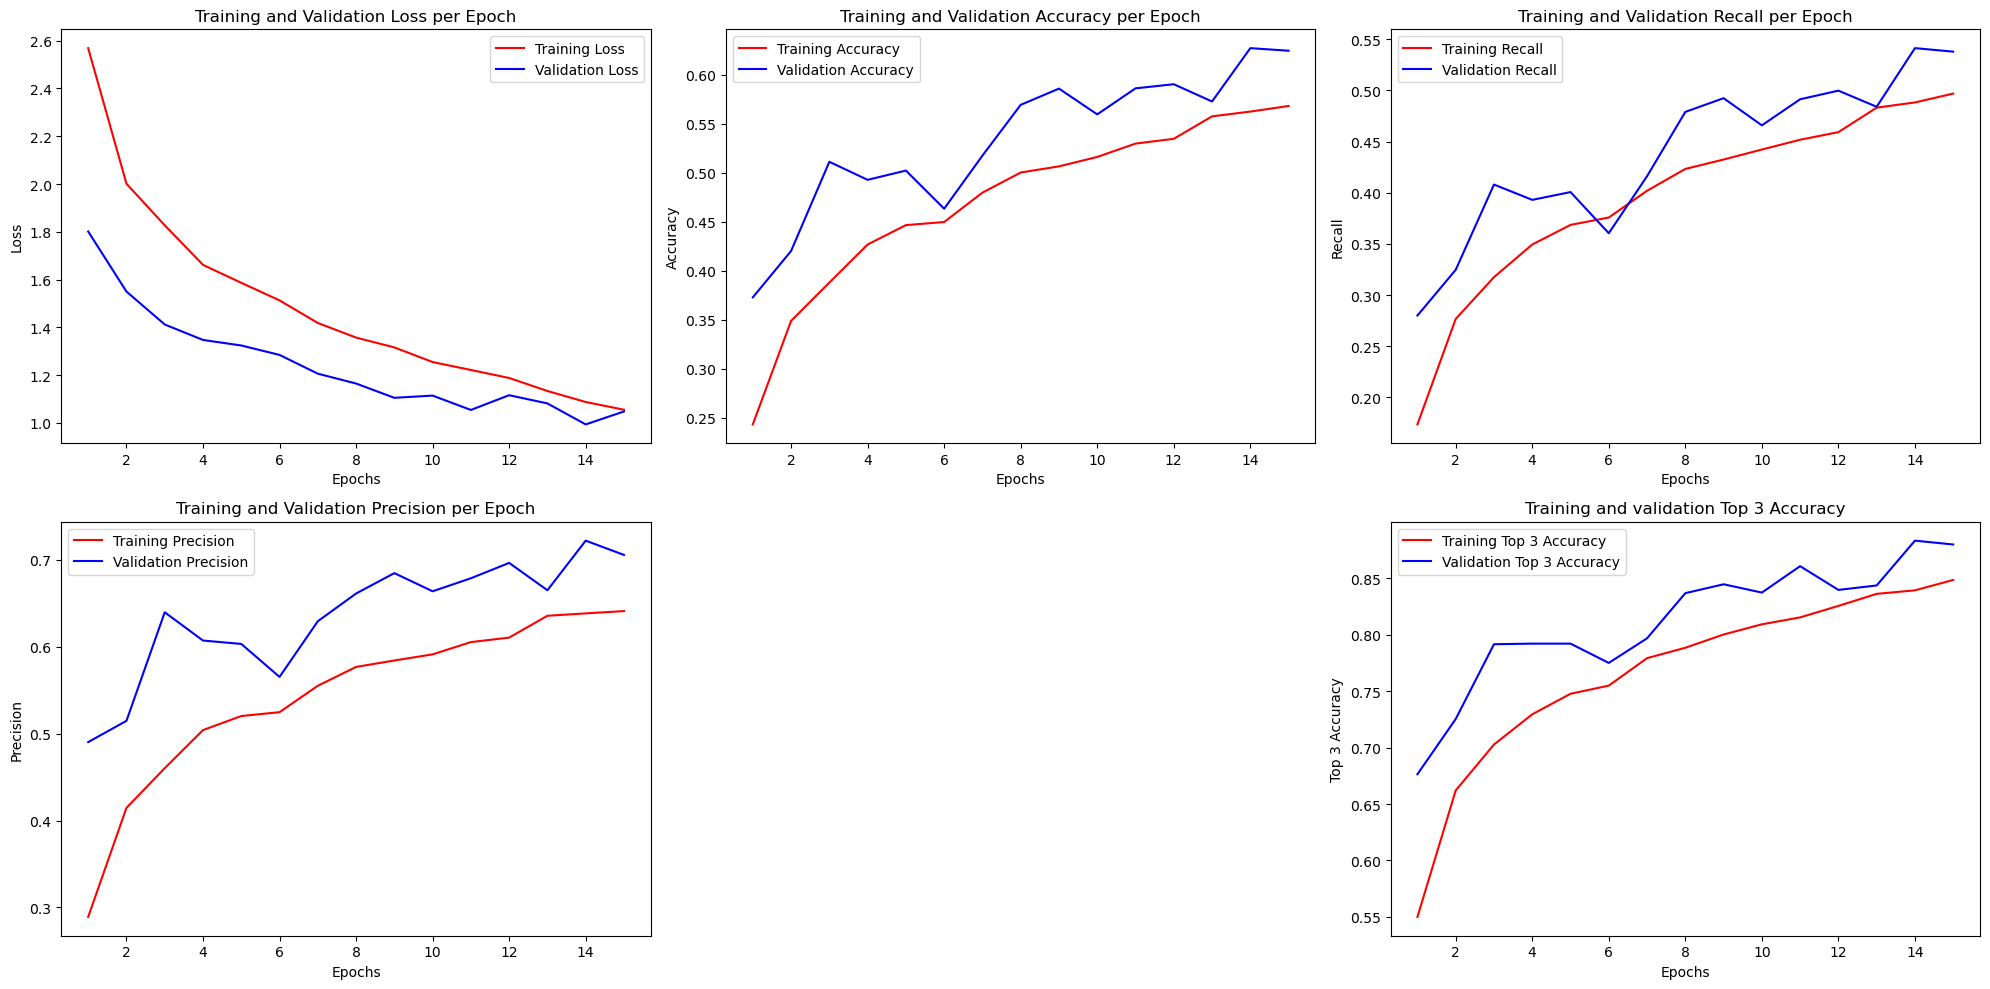

In [14]:
# Extract metrics from history for Resnet50
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_recall = history.history['recall']
val_recall = history.history['val_recall']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
# train_f1 = history.history['f1_m']
# val_f1 = history.history['val_f1_m']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot and save the metrics
plt.figure(figsize=(20, 10))

# Plot Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(current_path, 'vgg16_training_validation_loss.png'))

# Plot Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, train_acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'vgg16_training_validation_accuracy.png'))

# Plot Recall
plt.subplot(2, 3, 3)
plt.plot(epochs, train_recall, 'r-', label='Training Recall')
plt.plot(epochs, val_recall, 'b-', label='Validation Recall')
plt.title('Training and Validation Recall per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.savefig(os.path.join(current_path, 'vgg16_training_validation_recall.png'))

# Plot Precision
plt.subplot(2, 3, 4)
plt.plot(epochs, train_precision, 'r-', label='Training Precision')
plt.plot(epochs, val_precision, 'b-', label='Validation Precision')
plt.title('Training and Validation Precision per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig(os.path.join(current_path, 'vgg16_training_validation_precision.png'))

# Plot F1 Score
# plt.subplot(2, 3, 5)
# plt.plot(epochs, train_f1, 'r-', label='Training F1 Score')
# plt.plot(epochs, val_f1, 'b-', label='Validation F1 Score')
# plt.title('Training and Validation F1 Score per Epoch')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.savefig(os.path.join(current_path, 'resnet50_training_validation_f1_score.png'))

# Plot Top 3 Accuracy
plt.subplot(2, 3, 6)
plt.plot(epochs, train_top3_acc, 'r-', label='Training Top 3 Accuracy')
plt.plot(epochs, val_top3_acc, 'b-', label='Validation Top 3 Accuracy')
plt.title('Training and validation Top 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top 3 Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'vgg16_training_validation_top3_acc.png'))

plt.tight_layout()
plt.savefig(os.path.join(current_path, 'vgg16_all_metrics_plots.png'))
plt.show()


In [15]:
model.evaluate(val_batches)

/home/fall2019/qnd5128/miniconda3/envs/capstone_env_/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 75s 622ms/step - categorical_accuracy: 0.5870 - loss: 1.2394 - precision: 0.6608 - recall: 0.4759 - top_3_accuracy: 0.8929


[1.1762425899505615,
 0.621188223361969,
 0.7133516669273376,
 0.5449526906013489,
 0.8798633217811584]

In [16]:
predictions = model.predict(val_batches, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = val_batches.classes

119/119 ━━━━━━━━━━━━━━━━━━━━ 76s 624ms/step


In [17]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)
print(classification_report(val_batches.classes, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.27      0.63      0.38       131
           1       0.69      0.56      0.62       499
           2       0.50      0.49      0.49       394
           3       0.18      0.81      0.30        36
           4       0.59      0.59      0.59       679
           5       0.90      0.71      0.80      1932
           6       0.30      0.62      0.40        95
           7       0.27      1.00      0.43        38

    accuracy                           0.65      3804
   macro avg       0.46      0.68      0.50      3804
weighted avg       0.73      0.65      0.67      3804



## Transfer Learning using Vgg19 Model

In [ ]:
target_size = (224,224)
image_gen = ImageDataGenerator(
    preprocessing_function=vgg_19_preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_batches = image_gen.flow_from_directory(train_dir,
                                              target_size=target_size,
                                              color_mode='rgb',
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

val_batches = image_gen.flow_from_directory(val_dir,
                                            target_size=target_size,
                                            color_mode='rgb',
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle=False)

print(train_batches.class_indices)

In [ ]:
vgg19_base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg19_base_model.layers[:-10]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)
model = Model(inputs=vgg19_base_model.input, outputs=predictions)
model.summary()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.mixed_precision import set_global_policy

# Function to compute sample weights
def compute_sample_weights(labels, class_weights):
    sample_weights = np.array([class_weights[np.argmax(label)] for label in labels])
    return sample_weights

def generator_with_sample_weights(generator, class_weights):
    while True:
        x, y = next(generator)
        sample_weights = compute_sample_weights(y, class_weights)
        yield x, y, sample_weights


train_batches_with_weights = generator_with_sample_weights(train_batches, class_weights_dict)
valid_batches_with_weights = generator_with_sample_weights(val_batches, class_weights_dict)


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy, 
                       Precision(name='precision'), 
                       Recall(name='recall'), 
                       TopKCategoricalAccuracy(k=3, name='top_3_accuracy')])

checkpoint = ModelCheckpoint('vgg19_checkpoint.keras', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, verbose=1, mode='max', min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights=True, mode='max', verbose=1)

callbacks_list = [checkpoint, reduce_lr, early_stopping]

history = model.fit(
    train_batches_with_weights,
    validation_data=valid_batches_with_weights,
    steps_per_epoch=len(train_batches),
    validation_steps=len(val_batches),
    epochs=30,
    callbacks=callbacks_list
)

# Save the final model
model.save('vgg19_full_model_after_training.keras')

In [ ]:
# Extract metrics from history for Resnet50
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_recall = history.history['recall']
val_recall = history.history['val_recall']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
# train_f1 = history.history['f1_m']
# val_f1 = history.history['val_f1_m']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot and save the metrics
plt.figure(figsize=(20, 10))

# Plot Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(current_path, 'vgg19_training_validation_loss.png'))

# Plot Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, train_acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'vgg19_training_validation_accuracy.png'))

# Plot Recall
plt.subplot(2, 3, 3)
plt.plot(epochs, train_recall, 'r-', label='Training Recall')
plt.plot(epochs, val_recall, 'b-', label='Validation Recall')
plt.title('Training and Validation Recall per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.savefig(os.path.join(current_path, 'vgg19_training_validation_recall.png'))

# Plot Precision
plt.subplot(2, 3, 4)
plt.plot(epochs, train_precision, 'r-', label='Training Precision')
plt.plot(epochs, val_precision, 'b-', label='Validation Precision')
plt.title('Training and Validation Precision per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig(os.path.join(current_path, 'vgg19_training_validation_precision.png'))

# Plot F1 Score
# plt.subplot(2, 3, 5)
# plt.plot(epochs, train_f1, 'r-', label='Training F1 Score')
# plt.plot(epochs, val_f1, 'b-', label='Validation F1 Score')
# plt.title('Training and Validation F1 Score per Epoch')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.savefig(os.path.join(current_path, 'resnet50_training_validation_f1_score.png'))

# Plot Top 3 Accuracy
plt.subplot(2, 3, 6)
plt.plot(epochs, train_top3_acc, 'r-', label='Training Top 3 Accuracy')
plt.plot(epochs, val_top3_acc, 'b-', label='Validation Top 3 Accuracy')
plt.title('Training and validation Top 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top 3 Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'vgg19_training_validation_top3_acc.png'))

plt.tight_layout()
plt.savefig(os.path.join(current_path, 'vgg19_all_metrics_plots.png'))
plt.show()


In [ ]:
model.evaluate(val_batches)

In [ ]:
predictions = model.predict(val_batches, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = val_batches.classes

In [ ]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)
print(classification_report(val_batches.classes, predictions, zero_division=0))